<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> Megaline 
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Smart vs Ultra
</p>

---

The mobile company Megaline is unhappy to see that many of their customers are using legacy plans. They want to develop a model that can analyze customer behavior and recommend one of Megaline's new plans: Smart or Ultra.

You have access to the behavioral data of subscribers who have already switched to the new plans (from the Statistical Data Analysis sprint project). For this classification task you must create a model that chooses the correct plan. Since you have already done the data processing step, you can jump right into creating the model.

Develop a model that is as accurate as possible. In this project, the accuracy threshold is 0.75. Use the dataset to check the accuracy.

---

**`Data Dictionary`**:
 
**`calls`**: number of calls.  
**`minutes`**: total call duration in minutes.  
**`messages`**: number of text messages.  
**`mb_used`**: Internet traffic used in MB.  
**`is_ultra`**: plan for the current month (Ultra - 1, Smart - 0).


#  1. Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, root_mean_squared_error
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 

# 2. Load data and exploratory data analysis

In [3]:
megaline_df = pd.read_csv('users_behavior.csv')
megaline_df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
print('Summary of Megaline df:\n')
megaline_df.info()

Summary of Megaline df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**`DataFrame Review:`**  
**`Shape`**: **214** rows and **5** columns.  
There are no **`missing values`**.  
The **`dtypes`** are correct. Although the `calls` and `message` columns could be integers, they will remain as floats.  
**`Duplicates`** will be checked.  

In [5]:
duplicates = megaline_df.duplicated().sum()
print('Total duplicates:', duplicates)

Total duplicates: 0


In [6]:
print('Megaline Statistics:')
# Exclude column 'is_ultra'
df_without_ultra = megaline_df.drop(columns=['is_ultra'])
df_without_ultra.describe().transpose()

Megaline Statistics:


,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73


# 3. Data Splitting

The features (`X`) and the target variable (`y`) are selected.  
The data is split into training, validation, and test sets with a **60/20/20 ratio**.

**`X = features`**   
**`y = target`**

In [7]:
# Dropping the 'is_ultra' column from the features (X)
X = megaline_df.drop('is_ultra', axis=1)
print('Features columns:\n')
print(X.columns.tolist())

# Storing the 'is_ultra' column as the target (Y)
y = megaline_df['is_ultra']
print('\nTarget (is_ultra column):')
y.head(3)

Features columns:

['calls', 'minutes', 'messages', 'mb_used']

Target (is_ultra column):


0    0
1    0
2    0
Name: is_ultra, dtype: int64

In [8]:
# Create featutes (X) y target (y)
X = megaline_df.drop('is_ultra', axis=1)
y = megaline_df['is_ultra']

# First division: separate training from the rest (validation + testing)
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.4, random_state=12345)

# Second split: separate validation and testing from the remaining data
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=12345)

# Check data size
print("Data size:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Validation: {X_valid.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Data size:
Training: 1928 samples
Validation: 643 samples
Test: 643 samples


A **histogram** will be created using **`train_data`** to inspect the data before training the models.

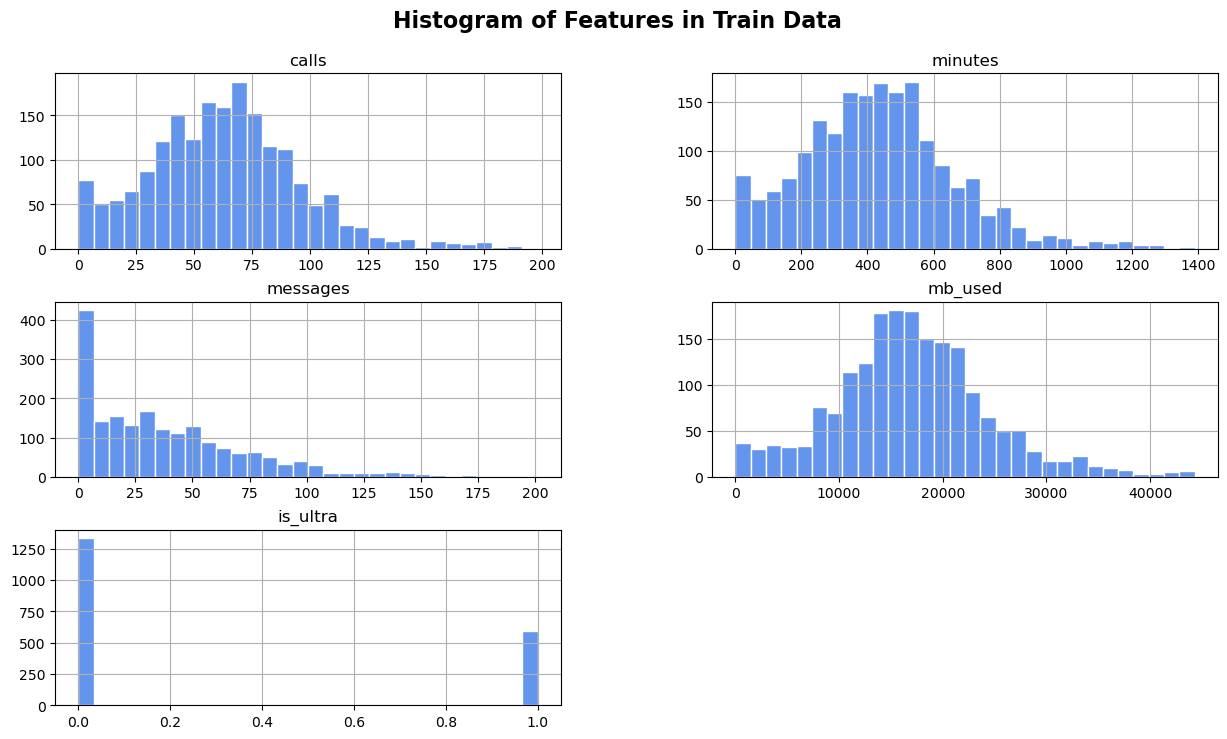

In [9]:
# Joining the feature data (X) with the target variable (y) to analyze correlations
train_data = X_train.join(y_train)
train_data.sample(5)

# Create a histogram
train_data.hist(bins=30, color='cornflowerblue', edgecolor='white', figsize=(15, 8))

# Title and labels
plt.suptitle('Histogram of Features in Train Data', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.9)  
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# Show the plot
plt.show()

**Analysis of 'Histogram of Features in Train Data'**

This histogram provides a visual representation of the distribution of various features in the training dataset, which can be helpful for understanding dataset characteristics and guiding the development of a machine learning model.

1. **`calls`**: There is a higher concentration of calls in the lower range, peaking around 80 to 100 calls.  
2. **`minutes`**: Most calls fall within the 100 to 150-minute range.  
3. **`messages`**: There are more messages in the lower range, with a peak around 75 to 100 messages.  
4. **`mb_used`**: Most users exhibit relatively low data usage, peaking around 10,000 to 20,000 MB.  
5. **`is_ultra`**: The majority of users are subscribed to the "smart" plan.  

# 4. Train and evaluate the models


- We will train and evaluate the two models: `DecisionTreeClassifier`, `RandomForestClassifier`, and `LogisticRegression`.
- We will calculate performance metrics such as `accuracy_score`.

## 4.1 Model 1: Decision Tree

In [10]:
# Variables to store the best 'max_depth' and 'best_accuracy'
max_depth = 0
best_accuracy = 0

# Loop over a range of max_depth values to find the optimal depth

for depth in range(1, 11): # from 1 to 10
    # Create a DecisionTreeClassifier with the specified max_depth
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    
    # Train the model using the training set
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    predictions_valid = model.predict(X_valid)
    
   # Calculate accuracy on the validation set
    accuracy_s = accuracy_score(y_valid, predictions_valid)
                                
    # Print the accuracy for the current max_depth
    print(f'max_depth = {depth}: {round(accuracy_s, 3)}')    
    
    # Update the best accuracy and corresponding max_depth if better accuracy is found
    if accuracy_s > best_accuracy:
        best_accuracy = accuracy_s
        max_depth = depth

# Print the best max_depth and its corresponding accuracy
print(f'\nBest max_depth = {max_depth}: {round(best_accuracy, 3)}')

max_depth = 1: 0.754
max_depth = 2: 0.782
max_depth = 3: 0.785
max_depth = 4: 0.779
max_depth = 5: 0.779
max_depth = 6: 0.784
max_depth = 7: 0.782
max_depth = 8: 0.779
max_depth = 9: 0.782
max_depth = 10: 0.774

Best max_depth = 3: 0.785


## Model 2: Random Forest

In [11]:
# Initialize variables for tracking the best model
best_RF_model = None
best_RF_accuracy = 0
best_RF_depth = 0
best_est = 0

# Create various models with different depth and estimator values
for est in range(1, 21):
    for depth in range(1, 41):
        
        # Create a model using the provided depth, number of estimators, and random_state
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Train the model using the training dataset
        RF_model.fit(X_train, y_train)

        # Predict the target values of the validation features
        RF_predictions_valid = RF_model.predict(X_valid)
       
        # Calculate the accuracy
        accuracy = accuracy_score(y_valid, RF_predictions_valid)

        # Determine the best model based on accuracy
        if accuracy > best_RF_accuracy:
            best_RF_model = RF_model
            best_RF_accuracy = accuracy
            best_RF_depth = depth
            best_est = est

# Print the best model and its details
print('Best Model:', best_RF_model)
print(f'Best Accuracy: {round(best_RF_accuracy * 100, 2)}%')
print('Best Depth:', best_RF_depth)
print('Best n_estimators:', best_est)

Best Model: RandomForestClassifier(max_depth=12, n_estimators=17, random_state=12345)
Best Accuracy: 80.56%
Best Depth: 12
Best n_estimators: 17


##  4.3 Logistic Regression

In [12]:
# Initialize and train the logistic regression model
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(X_train, y_train)

# Make predictions on the validation set
predictions_valid_lr = model_lr.predict(X_valid)

# Make predictions on the training and test sets
train_predictions = model_lr.predict(X_train)
test_predictions = model_lr.predict(X_test)

# Calculate accuracy for training, validation, and test sets
acc_tr_lr = accuracy_score(y_train, train_predictions)
acc_val_lr = accuracy_score(y_valid, predictions_valid_lr)
acc_ts_lr = accuracy_score(y_test, test_predictions)

# Print the accuracy results
print('\nAccuracy:')
print(f'Training set: {acc_tr_lr:.2f}')
print(f'Validation set: {acc_val_lr:.2f}')
print(f'Test set: {acc_ts_lr:.2f}')


Accuracy:
Training set: 0.75
Validation set: 0.76
Test set: 0.74


## 4.4 Sanity Check

In [13]:
# Target column for prediction
target = megaline_df['is_ultra']

# Average of is_ultra (target column)
predictions = pd.Series(target.mean(), index=target.index)

# Calculate the RMSE
rmse = root_mean_squared_error(target, predictions)
print('RMSE:', rmse)

RMSE: 0.46102797293043907


An RMSE of 0.4610 means that, on average, the prediction (the average of is_ultra) deviates 0.461 from the true value.  
More advanced models must have a lower RMSE than this to be considered better.

## 4.5 Comparison of Models

In [14]:
# Initialize accuracy variables for Decision Tree
acc_tr_dtc = accuracy_score(y_train, model.predict(X_train))
acc_val_dtc = best_accuracy  # Best accuracy from the loop for validation
acc_ts_dtc = accuracy_score(y_test, model.predict(X_test))

# Initialize RMSE for Decision Tree
rmse_dtc = root_mean_squared_error(y_valid, model.predict(X_valid))

# Initialize accuracy variables for Random Forest
acc_tr_rfc = accuracy_score(y_train, best_RF_model.predict(X_train))
acc_val_rfc = best_RF_accuracy  # Best accuracy from the loop for validation
acc_ts_rfc = accuracy_score(y_test, best_RF_model.predict(X_test))

# Initialize RMSE for Random Forest
rmse_rfc = root_mean_squared_error(y_valid, best_RF_model.predict(X_valid))

# RMSE for Logistic Regression (not valid)
rmse_lr = 0

# Create DataFrame for comparison
results = pd.DataFrame({
    'Model': ['Decision Tree Classifier', 'Random Forest Classifier', 'Logistic Regression'],
    'Training set accuracy': [acc_tr_dtc, acc_tr_rfc, acc_tr_lr],
    'Validation set accuracy': [acc_val_dtc, acc_val_rfc, acc_val_lr],
    'Test set accuracy': [acc_ts_dtc, acc_ts_rfc, acc_ts_lr],
    'RMSE Validation set': [rmse_dtc, rmse_rfc, rmse_lr]
})

# Print results
results

,Model,Training set accuracy,Validation set accuracy,Test set accuracy,RMSE Validation set
0,Decision Tree Classifier,0.889004,0.785381,0.788491,0.474874
1,Random Forest Classifier,0.912344,0.805599,0.799378,0.440910
2,Logistic Regression,0.750519,0.758942,0.740280,0.000000


# 5. Conclusions and Next Steps

**Conclusion DecisionTreeClassifier**.  
This model showed a good accuracy with **78.54%**, although it was not the highest, it had an acceptable performance. Normally, this type of model has a low accuracy but it is fast, and that speed was confirmed in this case.

**Conclusion RandomForestClassifier**.  
This model obtained the highest accuracy with **80.56%**. Typically, Random Forest models excel at having high accuracy at the cost of lower speed, which was also confirmed in this project.

**Conclusion LogisticRegression**.  
This model presented the lowest accuracy with only **75.89%**. In general, this model is expected to have average accuracy, but that was not demonstrated in this case. However, its speed was high, meeting the usual expectations.

---

**Model selection**  
The model that stood out the most was the **`RandomForestClassifier`**, as it met expectations by achieving the highest accuracy, close to **80%**. Although its speed was the lowest of the three models evaluated, this does not represent an obstacle, as its high accuracy amply compensates for it. In addition, I chose this model because its methodology, based on multiple decision trees, is ideal for this type of problem, since it provides more robust and generalizable results.